In [25]:
import os
import cv2
import math
import torch
import random
import warnings
import numpy as np
import onnxruntime
import pandas as pd
from typing import Any
from pathlib import Path
from matplotlib import pyplot as plt
from onnxruntime.quantization import QuantType
from segment_anything.utils.onnx import SamOnnxModel
from onnxruntime.quantization.quantize import quantize_dynamic
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Loads the spreadsheet

In [2]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent)

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Type Declarations and Helpful Functions

In [3]:
cv2.Image = np.ndarray
cv2.BinaryImage = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# get all the contours
def get_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    return cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# get contours that are optimized by the area - to - boudning rect metric, with large contours favored
def get_optimized_contours(contours: list[cv2.Contour], n: int = 1) -> list[cv2.Contour]:
    """ minimize the area of the rectangle and maximize contour area """
    adjusted_contours = []
    for contour in contours:
        _, _, w, h = cv2.boundingRect(contour)
        adjusted_contours.append([contour, cv2.contourArea(contour)**1.5/(w*h)])
    return [x[0] for x in sorted(adjusted_contours, key=lambda x: x[1], reverse=True)[:n]]

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

# draw the contours onto the image
def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

## Segment the leaves from the image

### Approach 1: Use large contours and an image mask

D7860206-18E3-45CC-B3E3-ADCFBD55DF81.jpg


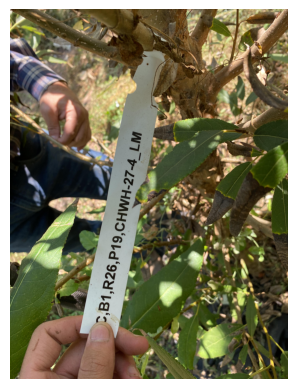

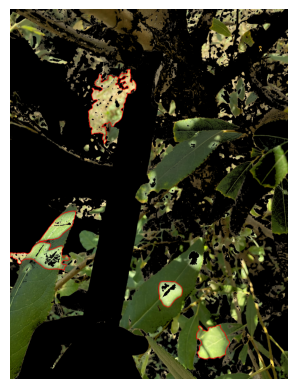

In [4]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 60), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_optimized_contours(get_contours(masked, False), n=5)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

img = get_image()
get_leaves(img, debug=True)

### Approach 2: Use Canny Edge detection and image inflation to detect contours

905A4A3D-E3D5-4E1D-8225-087E8C891814.jpg


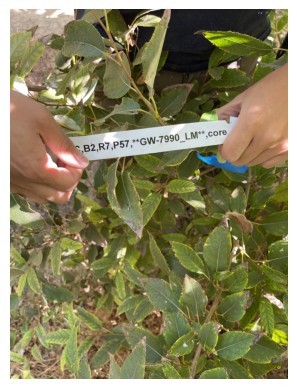

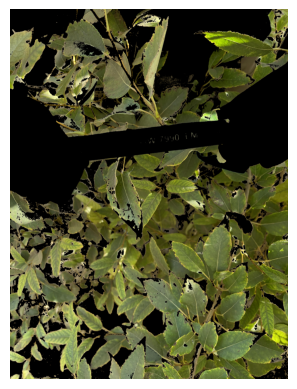

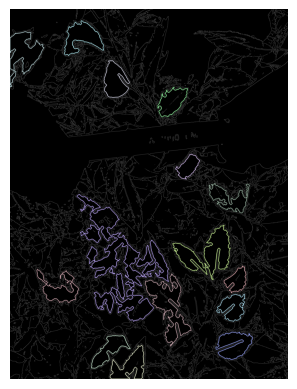

In [16]:
def patchify(img: cv2.BinaryImage, n: int, iters: int) -> Any:
    assert n % 2, "Side length must be odd"
    """ Outputs a square of points around the center (0, 0) with corners removed. """
    new_img = img.copy()
    for _ in range(iters):
        diff = n // 2
        kernel = np.ones((n, n), dtype=np.uint8)
        for y in range(-diff, diff+1):
            for x in range(-diff, diff+1):
                if abs(y) + abs(x) > diff + 1:
                    kernel[y+diff][x+diff] = 0
        new_img = cv2.dilate(new_img, kernel)
    return new_img

def filter_contours(contours: list[cv2.Contour], mask: cv2.BinaryImage) -> list[cv2.Contour]:
    l1, l2 = mask.shape[:2]
    contours = [i[0] for i in filter(
        lambda b: l1 // 16 < b[1][1] and l2 // 16 < b[1][0],
        [(cnt, cv2.boundingRect(cnt)[2:]) for cnt in contours]
    )]
    green_colored_contours = []
    for contour in contours: 
        mask_inside_contour = np.zeros_like(mask, np.uint8)
        mask_inside_contour = cv2.drawContours(mask_inside_contour, [contour], -1, 255, -1)
        mean = cv2.mean(mask, mask=mask_inside_contour)
        if mean[0] >= 100:
            green_colored_contours.append(contour)
    contours = get_optimized_contours(green_colored_contours, 15)
    return contours

def get_leaf_contours(img: cv2.Image, debug: bool = False) -> list[cv2.Contour]:

    # generate a mask for the image (colors we are interested in)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 50, 50), (80, 255, 255))
    masked = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    if debug: imshow(cv2.cvtColor(masked, cv2.COLOR_HSV2BGR))

    # find the edges using the Canny algorithm
    img_blur = cv2.GaussianBlur(masked, (23, 23), sigmaX=0, sigmaY=0) 
    edges = cv2.Canny(img_blur, threshold1=20, threshold2=40)
    dilated = cv2.bitwise_not(patchify(edges, 13, iters=2))

    # find the contours in the resulting image to determine which ones are leaves
    contours = filter_contours(cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], mask)

    # display found leaves
    if debug:
        drawn_contours = draw_contours(contours, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR))
        imshow(drawn_contours)

    return contours

img = get_image("905A4A3D-E3D5-4E1D-8225-087E8C891814.jpg")
_ = get_leaf_contours(img, debug=True)

Download and use Segmant Anything Model for segmenting knowing the leaf point

In [22]:
# const information
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_h"
SAM_MODEL_NAME = "sam_vit_h_4b8939.pth"
DATA_PATH = "seg_from_SAM"

# checks for the model being downloaded
if SAM_MODEL_NAME not in os.listdir():
    if os.name == 'nt':
        os.system(r"cd .. && .\scripts\SAM.bat && cd step2")
    else:
        os.system("cd .. && sh ./scripts/SAM.sh && cd step2")

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_MODEL_NAME)

Load and quantize the ONNX model from SAM

In [23]:
onnx_model_path = "onnx_model.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    
    
onnx_model_quantized_path = "onnx_model.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]

Start an ONNX runtime session for segmentation

In [24]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

In [ ]:
def get_image_encoding(image: cv2.Image):
    predictor.set_image(image)
    image_embedding = predictor.get_image_embedding().cpu().numpy()
    image_embedding.shape
    return image_embedding

### Approach 3: Use the Segment Anything Model to get the leaves, then filter them based on leaf-ness

Load model and set settings (see `scripts/SAM.[sh|bat]` for model download)

In [14]:
# const information
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_b"
SAM_MODEL_NAME = "sam_vit_b_01ec64.pth"
DATA_PATH = "seg_from_SAM"

# checks for the model being downloaded
if SAM_MODEL_NAME not in os.listdir():
    os.system('cd ..')
    if os.name == 'nt':
        os.system(r".\scripts\SAM.bat")
    else:
        os.system("sh ./scripts/SAM.sh")

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_MODEL_NAME)
sam.to(device=DEVICE)

MODEL = SamAutomaticMaskGenerator(
    model=sam
)

Go through each image and get the segments

EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg


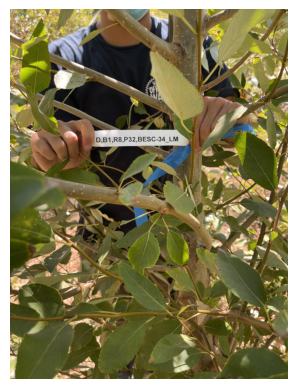

KeyboardInterrupt: 

In [17]:
SHRINK_RATIO = 0.2

# make directories to hold data
if DATA_PATH not in os.listdir():
    os.mkdir(DATA_PATH)
if "images" not in os.listdir(DATA_PATH):
    os.mkdir(f"{DATA_PATH}/images")

# get the segmentation for each image
for filename in SHEET_DATA["filename"]:
    
    # generate masks of the image
    img = get_image(filename)
    h, w = img.shape[:2]
    new_h, new_w = [round(SHRINK_RATIO * i) for i in [h, w]]
    resized = cv2.resize(img, (new_h, new_w), interpolation=cv2.INTER_AREA)
    masks = MODEL.generate(resized)

    # creates an array to hold the segmentations
    arr = np.zeros((new_h, new_w), dtype=np.int64)
    for i, mask in enumerate(masks):
        if mask['area'] < new_h * new_w // 500: continue
        arr += mask['segmentation'].astype(np.int64) * i   
    
    cv2.imwrite(f"{DATA_PATH}/images/{filename}", arr)

Convert the leaves to a list of contours

In [9]:
GREEN_LOWER = (20, 50, 50)
GREEN_UPPER = (80, 255, 255)

# filters the contours frm the segment anything model
# contours -> not too small -> not too far from label -> green avg. color
def filter_contours_from_SAM(img: cv2.Image, mask: cv2.Image) -> list[cv2.Contour]:

    img_h, img_w = img.shape[:2]
    diag_dist = math.sqrt(img_h**2 + img_w**2)

    # obtain the contours from the image
    edged = cv2.Canny(mask, threshold1=0, threshold2=0)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # determine the center point of the white label
    white = cv2.inRange(img, (200, 200, 200), (255, 255, 255))
    white_contour = max(
        cv2.findContours(
            cv2.GaussianBlur(white, (11, 11), sigmaX=0, sigmaY=0),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        ), 
        key=cv2.contourArea
    )
    x, y, w, h = cv2.boundingRect(white_contour)
    center_approx = (y+h//2, x+w//2)

    # filter those that are too far from the center
    close_contours = []
    for contour in contours:
        cx, cy, cw, ch = cv2.boundingRect(contour)
        cntr_center = (cy+ch//2, cx+cw//2)
        if math.sqrt((
            cntr_center[0]-center_approx[0])**2 + (cntr_center[1]-center_approx[1])**2
        ) < diag_dist / 2:
            close_contours.append(contour)
    
    # filter those whose average color are not in the right range
    green_contours = []
    for contour in close_contours:
        leaf_mask = cv2.drawContours(np.zeros((img_h, img_w)), [contour], -1, 255, cv2.FILLED)
        mean_color  = cv2.mean(img, mask=leaf_mask)
        if all([lower < col < upper for lower, col, upper in 
                zip(GREEN_LOWER, mean_color, GREEN_UPPER)]):
            green_contours.append(contour)

    return green_contours

filename = get_random_filename()
img = get_image(filename)
mask = cv2.imread(f"{DATA_PATH}/images/{filename}", cv2.IMREAD_GRAYSCALE)
contours = filter_contours_from_SAM(img, mask)
gray = grayscale(img)
imshow(draw_contours(contours, gray))

SyntaxError: invalid syntax (2692712807.py, line 45)

0C3DBD86-8588-48D6-B90C-AA694592E511.jpg


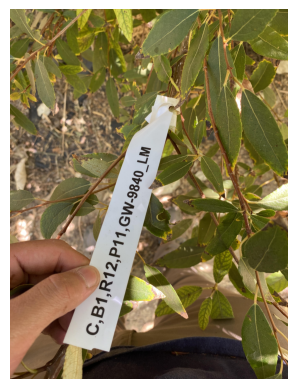

(68.11699779738284, 107.97524220915217, 121.69943281131897, 0.0)

In [10]:
img = get_image()
cv2.mean(img)